In [2]:
from scipy.stats import median_abs_deviation

import sys
sys.path.insert(0, '/home/workspace/mm_analysis')
sys.path.insert(0, '/home/workspace/')

from py_util import *
from utilities import *

hdir = '/home/workspace'
wdir = hdir + "/mm_analysis/EXP-01244/"
objdir = wdir + "quality_control/qc_objects/"

adata = sc.read_h5ad(objdir + "week3_qc_adata.h5ad")

# Generating QC labeled, unfiltered, processed adata

- Week 3 organoid only had enough for one 10X barcode

In [21]:
cr_outs_path = os.path.join(hdir, "mm_analysis/EXP-01244/data/EXP-01244_cr_outs")

# Dictionary mapping user-friendly sample names to their corresponding IDs
sample_dict = {
   'week2': "OR07965-01",    
   'week3': "OR07965-02", 
   'week4': "OR00001",
   'bm': "BMC07965-007",
   'msc': "CELL00911"
}

name_dict = {
   'week2': "Week 2",
   'week3': "Week 3", 
   'week4': "Week 4",
   'bm': "BMMC Start Sample",
   'msc': "MSC Start Sample"   
}

# Create reverse mapping from sample IDs to their user-friendly names
id_to_sample = {v: k for k, v in sample_dict.items()}

# Find all filtered_feature_bc_matrix.h5 files in the directory structure
h5_paths = [os.path.join(root, 'sample_filtered_feature_bc_matrix.h5') 
           for root, _, files in os.walk(cr_outs_path) 
           if 'sample_filtered_feature_bc_matrix.h5' in files]

# Get only the week3 starter h5 paths
paths = [path for path in h5_paths if "OR07965-02" in path]

# Dictionary to store AnnData objects for each sample
adatas = {}

# Process each H5 file
for path in paths:
    # Extract sample name from path
    name = path.split('per_sample_outs/')[1].split('/')[0]
    
    # Read the H5 file and create AnnData object
    adata = sc.read_10x_h5(path)
    adata.var_names_make_unique()

    adata.obs['sample'] = name

    adata.obs['base_sample'] = adata.obs['sample'].str.replace(r'_\d+$', '', regex=True)      # Add metadata column for batched replicates
    adata.obs['sample_type'] = adata.obs['base_sample'].replace(id_to_sample)                 # Add sample names (week2, week3, etc.)
    adata.obs['name'] = adata.obs['sample_type'].replace(name_dict)                           # Add pretty names (Week 2, Week 3, etc.)

    adatas[name] = adata.copy()

adata = ad.concat(adatas.values(), join='outer', merge='same')

adata.var["mt"] = adata.var_names.str.startswith("MT-")                 # mitochondrial genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))      # ribosomal genes
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))           # hemoglobin genes

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)

adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)                # calling outlier cells with log1p_total_counts greater than 5 MAD's
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)         # calling outlier cells with log1p_n_genes_by_counts greater than 5 MAD's
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)      # calling outlier cells with pct_counts_in_top_20_genes greater than 5 MAD's
)

# Call mt outlier cells with pct_counts_mt greater than 3 MAD's
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3)

# Run Scrublet for doublet detection
scrub = scrublet.Scrublet(adata.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)

# Add Scrublet results to cell metadata
adata.obs['doublet_score'] = doublet_scores
adata.obs['predicted_doublet'] = predicted_doublets

# Store log1p transformed normalized counts
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# Saving raw adata
adata.raw = adata

# Standard processing workflow
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

# Computing a range of leiden resolutions from 0-2 in increments of 0.1
res_range = np.round(np.arange(0, 2.2, 0.1), 1)
for res in res_range:
    sc.tl.leiden(
        adata, 
        flavor="igraph",
        key_added=f"leiden_{str(res).replace('.', '_')}",
        n_iterations=2,
        resolution=res
    )

adata.uns['leiden_ranges'] = [f'leiden_{i:.1f}'.replace('.', '_') for i in np.arange(0, 2.1, 0.1)]

adata.write(objdir + 'week3_qc_adata.h5ad', compression='gzip')

... storing 'sample' as categorical
... storing 'base_sample' as categorical
... storing 'sample_type' as categorical
... storing 'name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


In [15]:
def compute_qc(adata, metric, lower_q, upper_q):
    """
    Compares and plots quality check plots for your desired input metric. 
    
    Parameters:
    adata (AnnData): AnnData object containing the data
    metric (str): Name of the metric in adata.obs to analyze
    lower_q (float): Lower bound for quantile value
    upper_q (float): Upper bound for quantile value
    
    Outputs:
    Various statistical metrics and a subplot with histogram and UMAP colored by metric. 
    """
    data_metric = adata.obs[metric]
    mean = np.mean(data_metric)
    median = np.median(data_metric)
    q1 = np.quantile(data_metric, lower_q)
    q2 = np.quantile(data_metric, upper_q)
    total_cells = len(data_metric)

    print(f"{'_' * 30}\n")
    print(f"Mean value: {mean:.2f}")
    print(f"Median value: {median:.2f}\n")
    print(f"{lower_q} Quantile value: {q1:.2f}")
    print(f"Percent of cells below {q1:.2f}: {(sum(data_metric < q1)/total_cells) * 100:.2f}%")
    print(f"Counts below {q1:.2f}: {sum(data_metric < q1)}\n")
    print(f"{upper_q} Quantile value: {q2:.2f}")
    print(f"Percent of cells above {q2:.2f}: {(sum(data_metric > q2)/total_cells) * 100:.2f}%")
    print(f"Counts above {q2:.2f}: {sum(data_metric > q2)}\n")
    print(f"{'_' * 30}\n")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=60, facecolor='w', edgecolor='k')
    
    sns.histplot(data_metric, bins=100, ax=ax1)
    ax1.axvline(mean, color='yellow', label='Mean')
    ax1.axvline(q1, color='red', label=f'{lower_q} Quantile')
    ax1.axvline(q2, color='red', label=f'{upper_q} Quantile')
    ax1.legend()
    ax1.set_title(f'Distribution of {metric}')
    
    sc.pl.umap(adata, color=metric, show=False, ax=ax2, vmax='p95')
    ax2.set_title(f'UMAP colored by {metric}')
    
    plt.tight_layout()
    plt.show()

______________________________

Mean value: 0.10
Median value: 0.03

0 Quantile value: 0.00
Percent of cells below 0.00: 0.00%
Counts below 0.00: 0

0.95 Quantile value: 0.33
Percent of cells above 0.33: 4.95%
Counts above 0.33: 54

______________________________



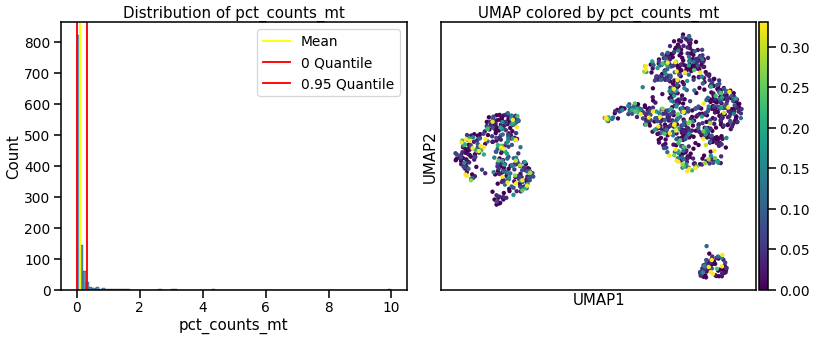

______________________________

Mean value: 0.10
Median value: 0.08

0.01 Quantile value: 0.03
Percent of cells below 0.03: 0.55%
Counts below 0.03: 6

0.95 Quantile value: 0.19
Percent of cells above 0.19: 3.75%
Counts above 0.19: 41

______________________________



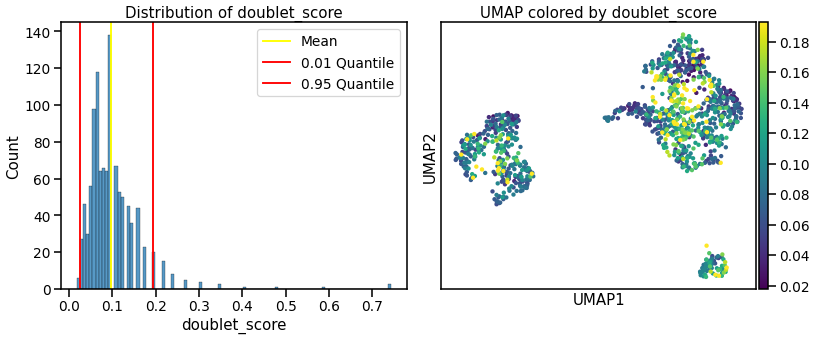

______________________________

Mean value: 8.35
Median value: 8.32

0.01 Quantile value: 6.26
Percent of cells below 6.26: 1.01%
Counts below 6.26: 11

0.95 Quantile value: 10.18
Percent of cells above 10.18: 5.04%
Counts above 10.18: 55

______________________________



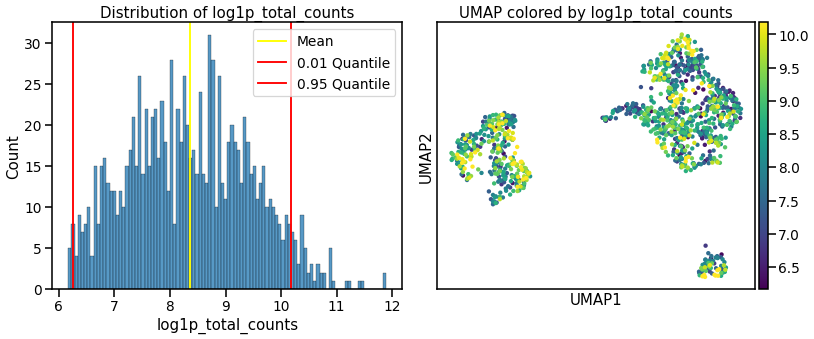

______________________________

Mean value: 7.54
Median value: 7.58

0.01 Quantile value: 6.04
Percent of cells below 6.04: 1.01%
Counts below 6.04: 11

0.95 Quantile value: 8.65
Percent of cells above 8.65: 4.95%
Counts above 8.65: 54

______________________________



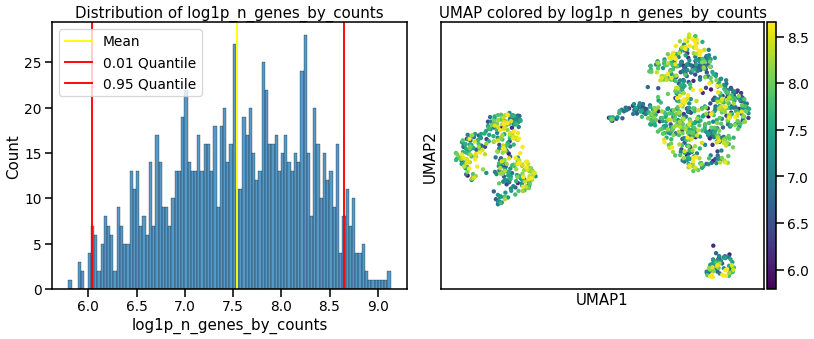

______________________________

Mean value: 18.03
Median value: 17.51

0.01 Quantile value: 10.48
Percent of cells below 10.48: 1.01%
Counts below 10.48: 11

0.95 Quantile value: 25.79
Percent of cells above 25.79: 5.04%
Counts above 25.79: 55

______________________________



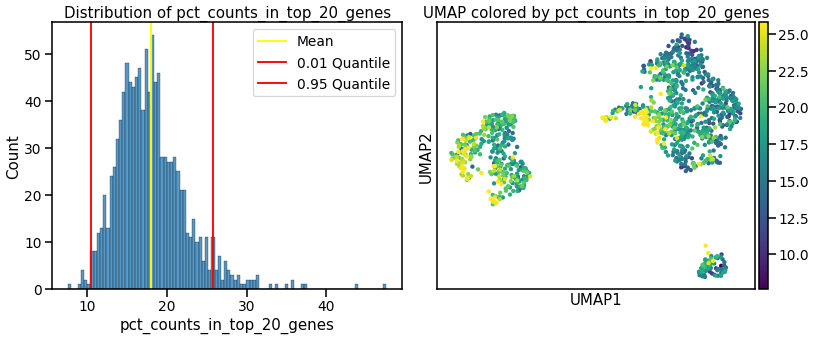

In [16]:
compute_qc(adata, 'pct_counts_mt', 0, 0.95)
compute_qc(adata, 'doublet_score', 0.01, 0.95)
compute_qc(adata, 'log1p_total_counts', 0.01, 0.95)
compute_qc(adata, 'log1p_n_genes_by_counts', 0.01, 0.95)
compute_qc(adata, 'pct_counts_in_top_20_genes', 0.01, 0.95)

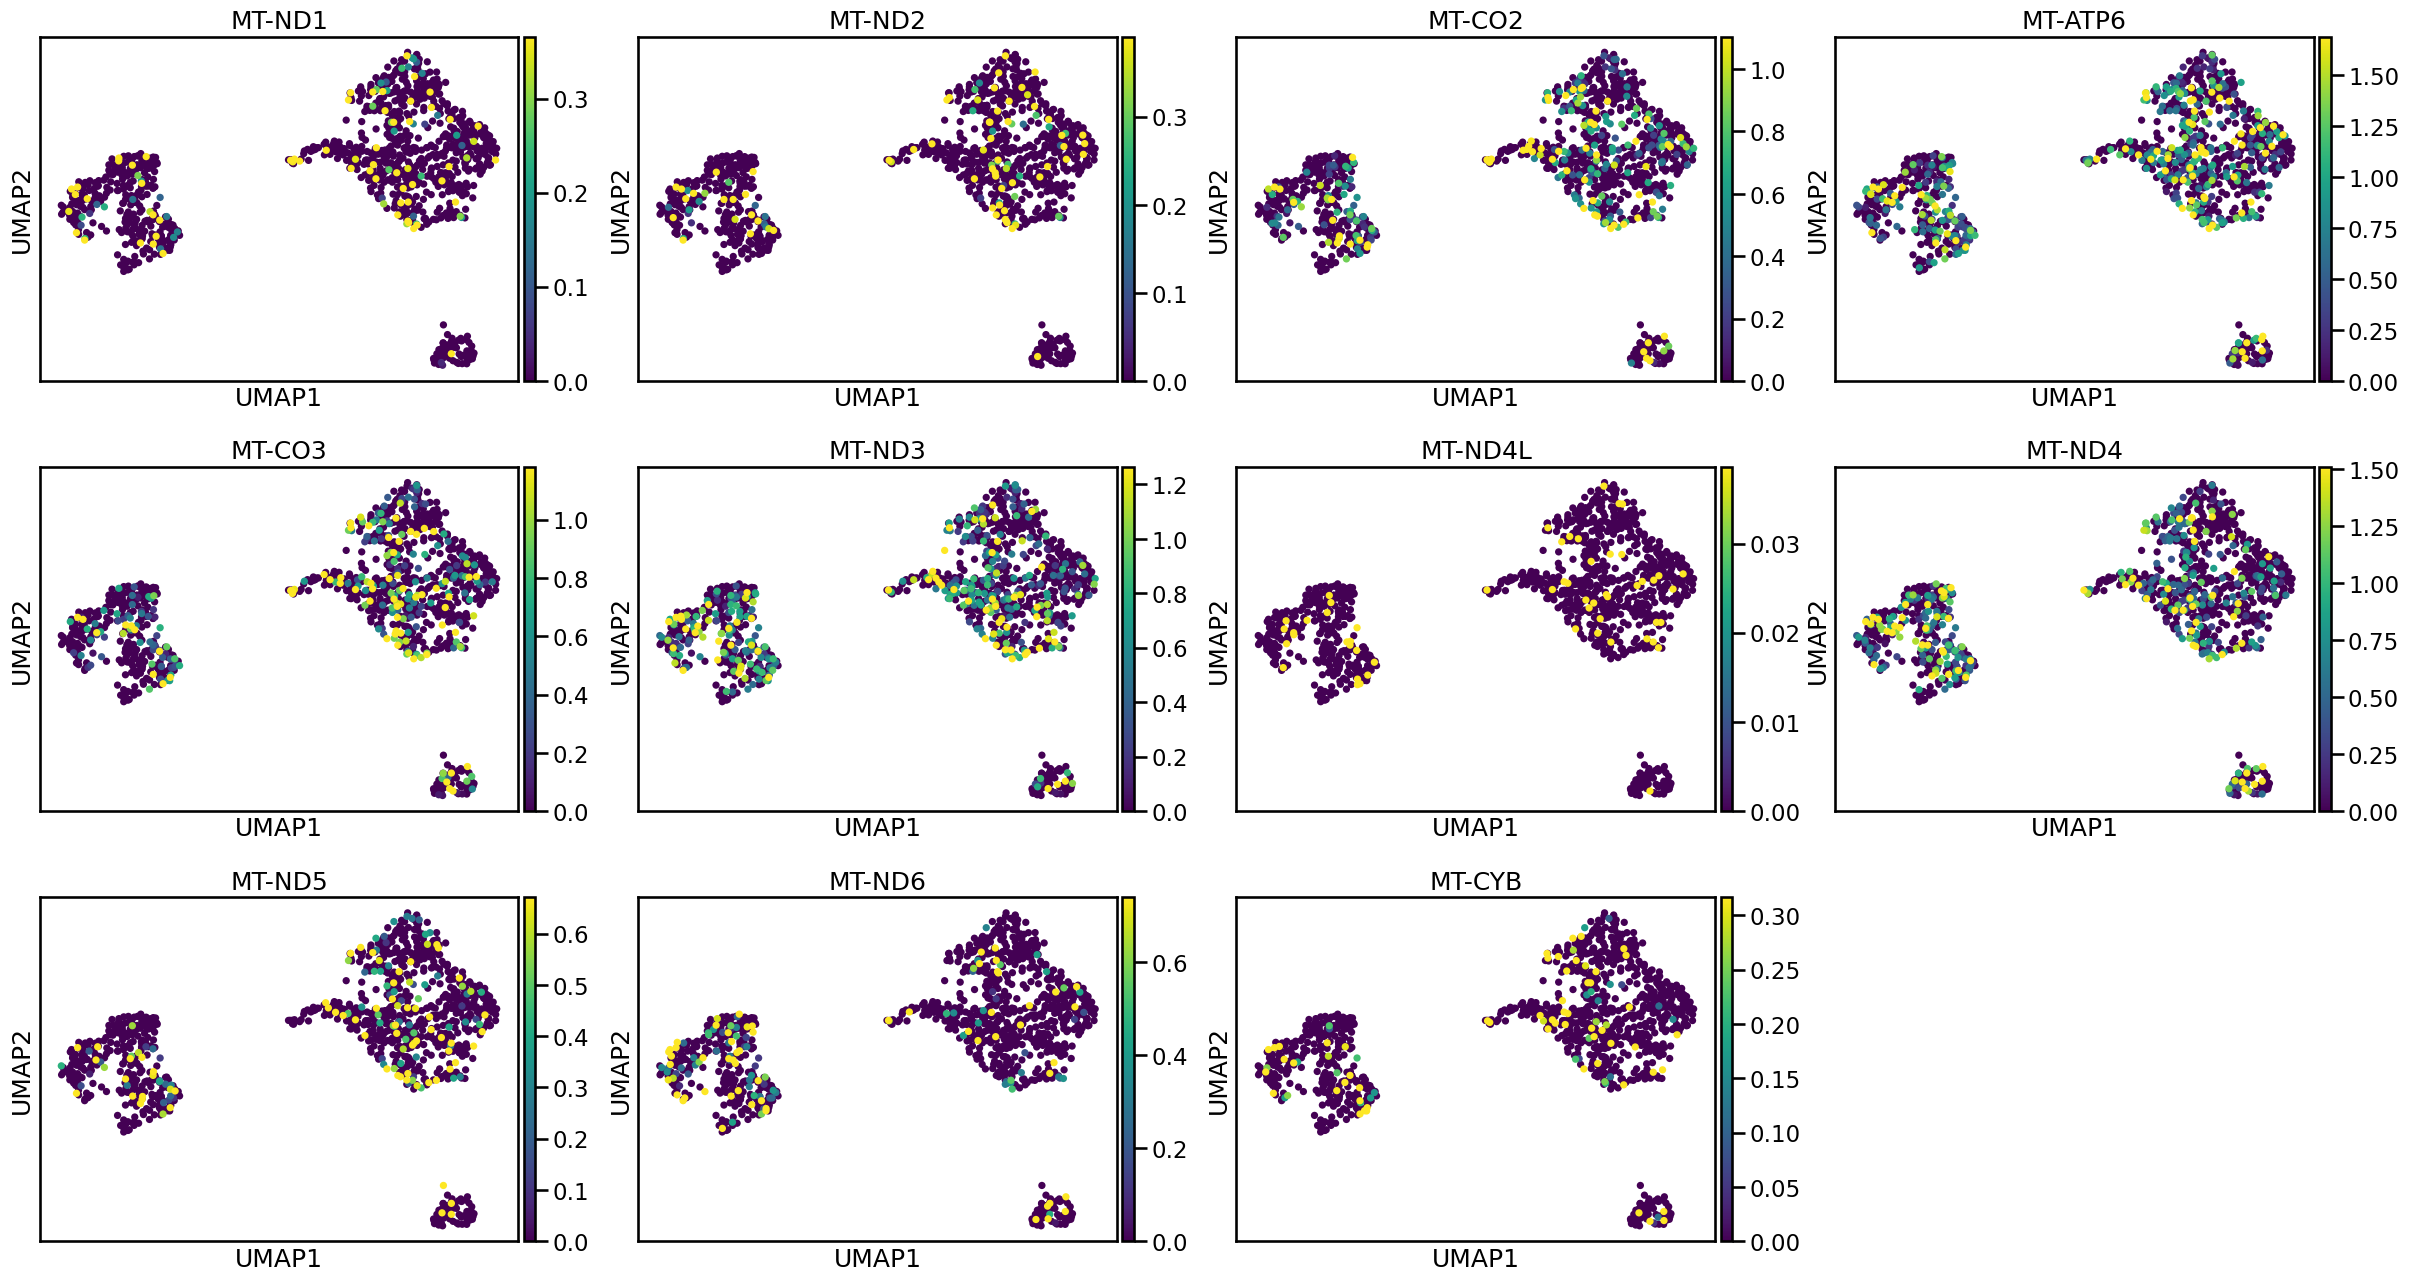

In [20]:
genes = list(adata.var.index)
mt_genes = [gene for gene in genes if "MT-" in gene]

sc.pl.umap(
    adata,
    color=mt_genes,
    vmax='p95'
)